In [1]:
# prompt: install the following libraries

# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install pymongo
# !pip install yfinance
# !pip install tensorflowjs


In [2]:
# Import necessary libraries
import yfinance as yf
from pymongo import MongoClient
from datetime import datetime
import matplotlib.pyplot as plt
import pymongo
import pandas as pd
import requests
from bson import ObjectId
from bson.binary import Binary
import glob
import tensorflow as tf
import tensorflowjs as tfjs

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, RNN, LSTMCell, LSTM
from tensorflow.keras.models import load_model, save_model
from tensorflow import function
from bson.binary import Binary
import pickle
import io

from sklearn.metrics import mean_squared_error, mean_absolute_error

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
file_path = '/content/gdrive/My Drive/Colab Notebooks/config.env'

from pathlib import Path
config_path = Path('/content/gdrive/My Drive/Colab Notebooks/config.env')
config_data = config_path.read_text()

Document found for symbol 8AZ.SI
Model keys found in document
Model found for symbol 8AZ.SI. Using existing model.
2/2 [==============================] - 1s 8ms/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 128)           66560     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 25)                1625      
                                                                 
 dense_1 (Dense)             (None, 1)                 26        
                                                                 
Total params: 117619 (459.45 KB)
Trainable params: 117619 (459.45 KB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________

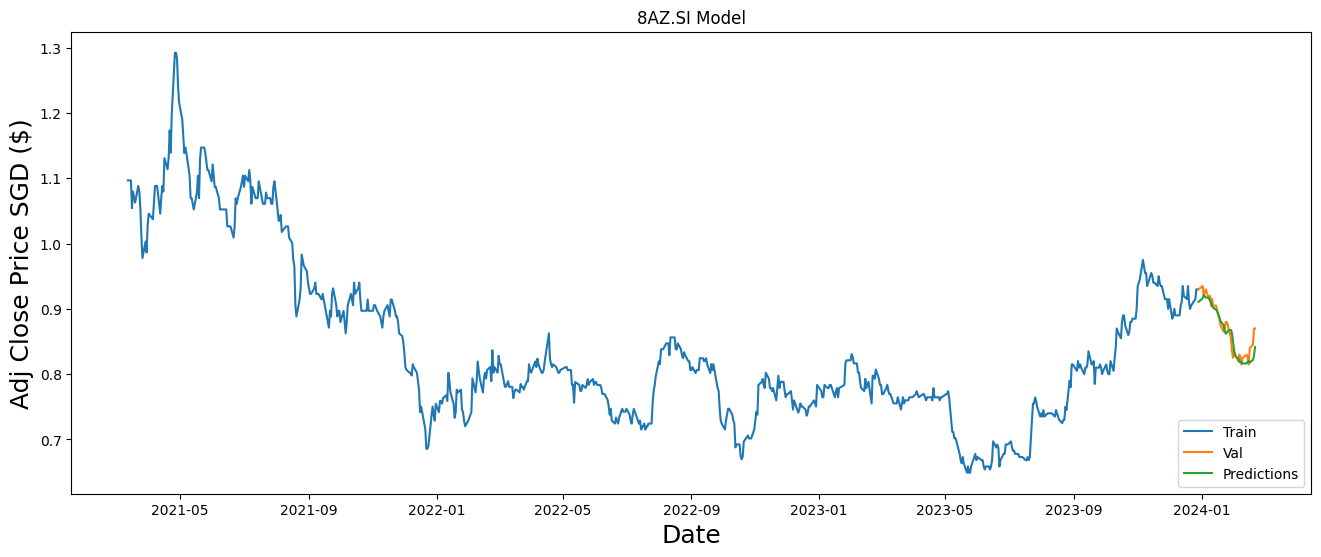

In [8]:
def connect_to_db():
    with open('/content/gdrive/MyDrive/Colab Notebooks/config.env', 'r') as file:
        connection_string = file.read().strip()

    connection_string = connection_string.replace('ATLAS_URI=', '')

    client = pymongo.MongoClient(connection_string)
    db = client['bullsai']
    return db

def download_data(symbol, start_date, end_date):
    db = connect_to_db()
    collection = db['ticker_data']
    data = collection.find_one({"symbol": symbol})

    if data is not None and 'transactions' in data:
        # Convert the data to a DataFrame
        dataDF = pd.DataFrame(data['transactions'])
        dataDF = dataDF.set_index('Date')

        # Convert the index to datetime
        dataDF.index = pd.to_datetime(dataDF.index)

        # Filter the data for the date range
        mask = (dataDF.index >= start_date) & (dataDF.index <= end_date)
        dataDF = dataDF.loc[mask]
        return dataDF

    return None

def create_dataset(data):
    data = data.filter(['Adj Close'])
    dataset = data.values
    training_data_len = int(np.ceil( len(dataset) * .95 ))
    return dataset, training_data_len

def scale_data(dataset):
    scaler = MinMaxScaler(feature_range=(0,1))
    return scaler.fit_transform(dataset), scaler

def create_training_data(scaled_data, training_data_len):
    train_data = scaled_data[0:int(training_data_len), :]
    x_train = []
    y_train = []
    for i in range(60, len(train_data)):
        x_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])
    return np.array(x_train), np.array(y_train)

def reshape_data(x_train):
    return np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

def create_test_data(scaled_data, dataset, training_data_len):
    test_data = scaled_data[training_data_len - 60: , :]
    x_test = []
    y_test = dataset[training_data_len:, :]
    for i in range(60, len(test_data)):
        x_test.append(test_data[i-60:i, 0])
    return np.array(x_test), y_test

def make_predictions(model, x_test, scaler):
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))
    predictions = model.predict(x_test)
    return scaler.inverse_transform(predictions)

def plot_data(data, training_data_len, predictions, symbol):
    train = data[:training_data_len]
    valid = data[training_data_len:].copy()
    valid.loc[:, 'Predictions'] = predictions
    plt.figure(figsize=(16,6))
    plt.title(symbol + ' Model')
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Adj Close Price SGD ($)', fontsize=18)
    plt.plot(train['Adj Close'])
    plt.plot(valid[['Adj Close', 'Predictions']])
    # plt.gcf().autofmt_xdate()  # update this line
    plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
    return plt  # Return the plot object


def build_and_train_model(x_train, y_train):
    model = Sequential()
    # model.add(RNN(LSTMCell(128), return_sequences=True, input_shape=(x_train.shape[1], 1)))
    # model.add(RNN(LSTMCell(64), return_sequences=False))
    model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(x_train, y_train, batch_size=1, epochs=2)
    return model

def calculate_rmse(predictions, y_test):
    return np.sqrt(np.mean(((predictions - y_test) ** 2)))

def save_model(model, model_path):
    model.save(model_path)

def load_model_if_exists(model_path):
    if os.path.exists(model_path):
        return load_model(model_path)
    else:
        return None

def load_model_from_db(symbol):
    # Connect to MongoDB
    db = connect_to_db()
    collection = db['ticker_data']
    doc = collection.find_one({'symbol': symbol})

    if doc is not None:
        print(f"Document found for symbol {symbol}")
        if 'model_json' in doc and 'model_weights' in doc:
            print("Model keys found in document")
            binary_model_json = doc['model_json']
            binary_model_weights = doc['model_weights']

            # Write the binary model.json and .bin files to temporary files
            tfjs_target_dir = f"tfjs_models/{symbol}_model"
            os.makedirs(tfjs_target_dir, exist_ok=True)
            with open(f"{tfjs_target_dir}/model.json", 'wb') as f:
                f.write(binary_model_json)
            for i, binary_model_weight in enumerate(binary_model_weights):
                with open(f"{tfjs_target_dir}/group1-shard{i+1}of{len(binary_model_weights)}.bin", 'wb') as f:
                    f.write(binary_model_weight)

            # Load the model from the temporary files
            model = tfjs.converters.load_keras_model(f"{tfjs_target_dir}/model.json")

            # Delete the temporary files
            os.remove(f"{tfjs_target_dir}/model.json")
            for bin_file_path in glob.glob(f"{tfjs_target_dir}/*.bin"):
                os.remove(bin_file_path)
        else:
            print("Model keys not found in document")
            model = None
    else:
        print(f"No document found for symbol {symbol}")
        model = None

    return model


def save_model_to_db(model, symbol):
    # Save the model in TensorFlow.js format
    tfjs_target_dir = f"tfjs_models/{symbol}_model"
    tfjs.converters.save_keras_model(model, tfjs_target_dir)

    # Connect to MongoDB
    db = connect_to_db()
    collection = db['ticker_data']

    # Read the model.json file and convert it to binary
    with open(f"{tfjs_target_dir}/model.json", 'rb') as f:
        binary_model_json = Binary(f.read())

    # Read the .bin files and convert them to binary
    binary_model_weights = []
    for bin_file_path in glob.glob(f"{tfjs_target_dir}/*.bin"):
        with open(bin_file_path, 'rb') as f:
            binary_model_weights.append(Binary(f.read()))

    # Store the binary model.json and .bin files in MongoDB
    collection.update_one({'symbol': symbol}, {'$set': {'model_json': binary_model_json, 'model_weights': binary_model_weights}}, upsert=True)

    # Delete the temporary files
    os.remove(f"{tfjs_target_dir}/model.json")
    for bin_file_path in glob.glob(f"{tfjs_target_dir}/*.bin"):
        os.remove(bin_file_path)

def load_model(model_path):
    import tensorflow as tf
    # Load the Keras model
    model = tf.keras.models.load_model(model_path)
    return model

def convert_model_to_tfjs(model, tfjs_model_path):
    import tensorflowjs as tfjs
    # Convert the model to TensorFlow.js format
    tfjs.converters.save_keras_model(model, tfjs_model_path)


def save_plot_to_db(symbol, plot_data):
    # Connect to MongoDB
    db = connect_to_db()
    collection = db['ticker_data']

    # Convert plot data to binary format
    buf = io.BytesIO()
    plot_data.savefig(buf, format='png')
    buf.seek(0)
    plot_binary = buf.getvalue()

    # Save plot to MongoDB under the document corresponding to the symbol
    query = {'symbol': symbol}
    update = {'$set': {'plot_data': Binary(plot_binary)}}
    collection.update_one(query, update, upsert=True)



def main(symbol, start_date, end_date):
    # Use the new download_data function
    data = download_data(symbol, start_date, end_date)

    if data is None:
        print(f"No data found on {symbol}. Exiting.")
        return

    dataset, training_data_len = create_dataset(data)
    scaled_data, scaler = scale_data(dataset)

    # Use the new load_model_from_db function
    model = load_model_from_db(symbol)

    if model is None:
        print(f"No model found for symbol {symbol}. Please train a model first.")

        # Create the training data
        x_train, y_train = create_training_data(scaled_data, training_data_len)
        x_train = reshape_data(x_train)

        # Build and train the model
        model = build_and_train_model(x_train, y_train)

        # Make predictions
        x_test, y_test = create_test_data(scaled_data, dataset, training_data_len)
        predictions = make_predictions(model, x_test, scaler)

        # Generate the plot
        plot = plot_data(data, training_data_len, predictions, symbol)

        # Save the plot to MongoDB
        save_plot_to_db(symbol, plot)

        # Save the model to MongoDB
        save_model_to_db(model, symbol)
    else:
        print(f"Model found for symbol {symbol}. Using existing model.")

        x_test, y_test = create_test_data(scaled_data, dataset, training_data_len)
        predictions = make_predictions(model, x_test, scaler)
        plot_data(data, training_data_len, predictions, symbol)

    model.summary()

main("8AZ.SI", "2000-01-01", datetime.today())